In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from IPython.display import display
import seaborn as sns
from matplotlib import font_manager, rc, rcParams
from sklearn.model_selection import train_test_split
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
rcParams['axes.unicode_minus'] = False
%matplotlib notebook

In [3]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,random_state=0)

scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)

svm = SVC().fit(X_train_scaled,y_train)

X_test_scaled = scaler.transform(X_test)
print('테스트 점수 : {:.2f}'.format(svm.score(X_test_scaled,y_test)))

테스트 점수 : 0.97


## 데이터 전처리와 매개변수 선택

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[0.001,0.01,0.1,1,10,100],'gamma':[0.001,0.01,0.1,1,10,100]}

grid = GridSearchCV(SVC(),param_grid=param_grid,cv=5).fit(X_train_scaled,y_train)

print('최상의 교차 검증 정확도 : {:.2f}'.format(grid.best_score_))
print('test score : {:.2f}'.format(grid.score(X_test_scaled,y_test)))
print('best_parametor :',grid.best_params_)

최상의 교차 검증 정확도 : 0.98
test score : 0.97
best_parametor : {'C': 1, 'gamma': 1}


## 파이프라인 구축하기

In [9]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler',MinMaxScaler())
                ,('svm',SVC())])
pipe.fit(X_train,y_train)
print('test score : {:.2f}'.format(pipe.score(X_test,y_test)))

test score : 0.97


## 그리드 서치에 파이프라인 적용하기

In [11]:
param_grid = {'svm__C':[0.001,0.01,0.1,1,10,100],'svm__gamma':[0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(pipe,param_grid=param_grid,cv=5).fit(X_train,y_train)

print('best valid score : {:.2f}'.format(grid.best_score_))
print('test score : {:.2f}'.format(grid.score(X_test,y_test)))
print('best params :',grid.best_params_)

best valid score : 0.98
test score : 0.97
best params : {'svm__C': 1, 'svm__gamma': 1}


<IPython.core.display.Javascript object>


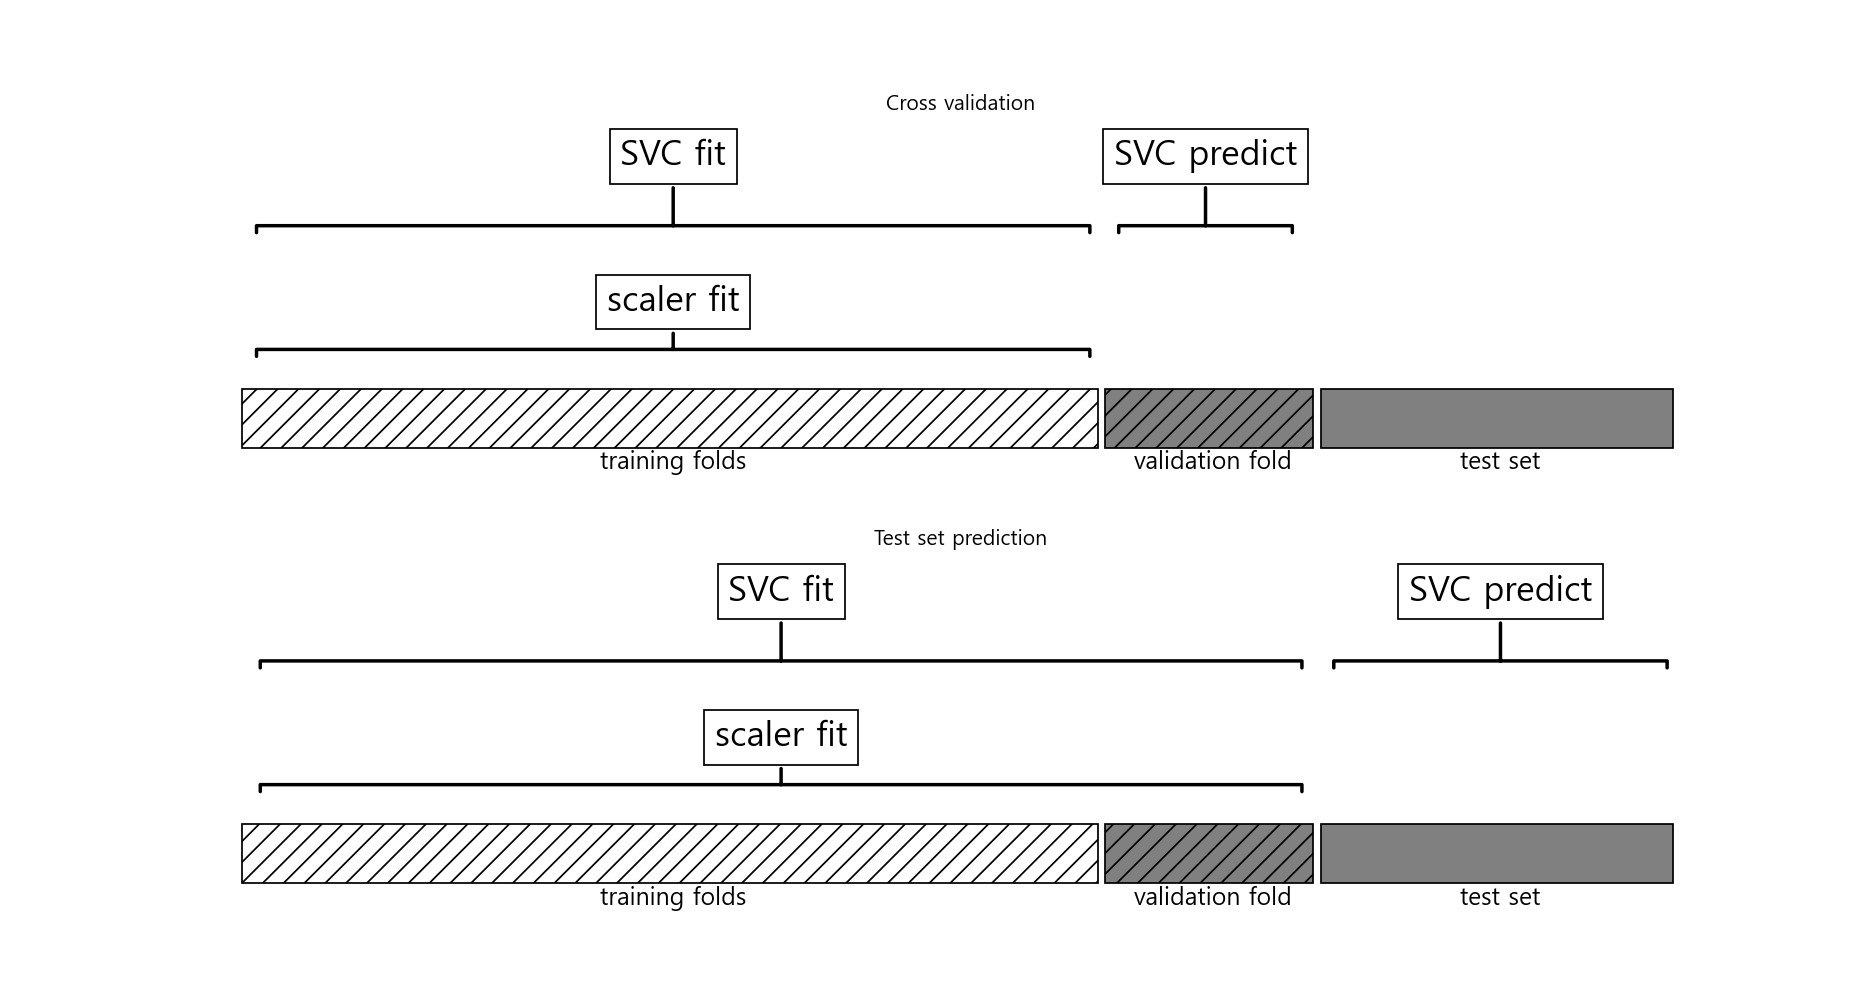

In [12]:
mglearn.plots.plot_proper_processing()

### 정보 누설에 대한 예시

In [14]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100,10000))
y = rnd.normal(size=(100,))

from sklearn.feature_selection import SelectPercentile, f_regression
select = SelectPercentile(score_func=f_regression,percentile=5).fit(X,y)
X_selected = select.transform(X)
print('X_selected.shape :',X_selected.shape)

X_selected.shape : (100, 500)


In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

print('교차 검증 점수 : {:.2f}'.format(np.mean(cross_val_score(Ridge(), X_selected,y,cv=5))))

교차 검증 점수 : 0.91


In [17]:
pipe = Pipeline([('select',SelectPercentile(score_func=f_regression,percentile=5))
                ,('ridge',Ridge())])
print('교차 검증 점수(파이프라인) : {:.2f}'.format(np.mean(cross_val_score(pipe,X,y,cv=5))))

교차 검증 점수(파이프라인) : -0.25


## 파이프라인 인터페이스

### make_pipeline을 사용한 파이프라인 생성

In [18]:
from sklearn.pipeline import make_pipeline

pipe_long = Pipeline([('scaler',MinMaxScaler()),('svm',SVC(C=100))])
pipe_short = make_pipeline(MinMaxScaler(),SVC(C=100))

In [19]:
print('파이프라인 단계 :\n',pipe_short.steps)

파이프라인 단계 :
 [('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(),PCA(n_components=2),StandardScaler())
print('파이프라인 단계 :\n',pipe.steps)

파이프라인 단계 :
 [('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


### 단계 속성에 접근하기

In [22]:
pipe.fit(cancer.data)
components = pipe.named_steps['pca'].components_
print('components.shape :',components.shape)

components.shape : (2, 30)


### 그리드 서치 안의 파이프라인 속성에 접근하기

In [27]:
from sklearn.linear_model import LogisticRegression

#1. 파이프라인 만들기
pipe = make_pipeline(StandardScaler(),LogisticRegression(max_iter=1000))

#2. parametor_grid 먄들기
param_grid = {'logisticregression__C':[0.01,0.1,1,10,100]}

#3. 그리드 서치
X_trian,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,random_state=4)
grid = GridSearchCV(pipe,param_grid=param_grid,cv=5)
grid.fit(X_train,y_train)

print('best model :\n',grid.best_estimator_)

best model :
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.01, max_iter=1000))])


In [29]:
print('로지스틱 회귀 단계 :\n',grid.best_estimator_.named_steps['logisticregression'])
print('로지스틱 회귀 계수 :\n',grid.best_estimator_.named_steps['logisticregression'].coef_)

로지스틱 회귀 단계 :
 LogisticRegression(C=0.01, max_iter=1000)
로지스틱 회귀 계수 :
 [[-0.00524716 -0.00656512 -0.00131367 -0.00582785  0.01038074  0.01544566
   0.02639562  0.01837953 -0.03570718  0.02549812 -0.02597652  0.0311963
  -0.01858824 -0.0246899  -0.03602962  0.01103394  0.04707241  0.01934448
   0.0436609   0.03875114 -0.02366892  0.00345743 -0.01633742 -0.03664607
  -0.0207974   0.00755667  0.02021546  0.03801215 -0.00252811  0.01696274]]


## 전처리와 모델의 매개변수를 위한 그리드 서치

In [30]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train,X_test,y_train,y_test = train_test_split(boston.data,boston.target,random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(),Ridge())

param_grid = {'polynomialfeatures__degree':[1,2,3]
             ,'ridge__alpha':[0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(pipe, param_grid=param_grid,cv=5,n_jobs=-1).fit(X_train,y_train)

<IPython.core.display.Javascript object>


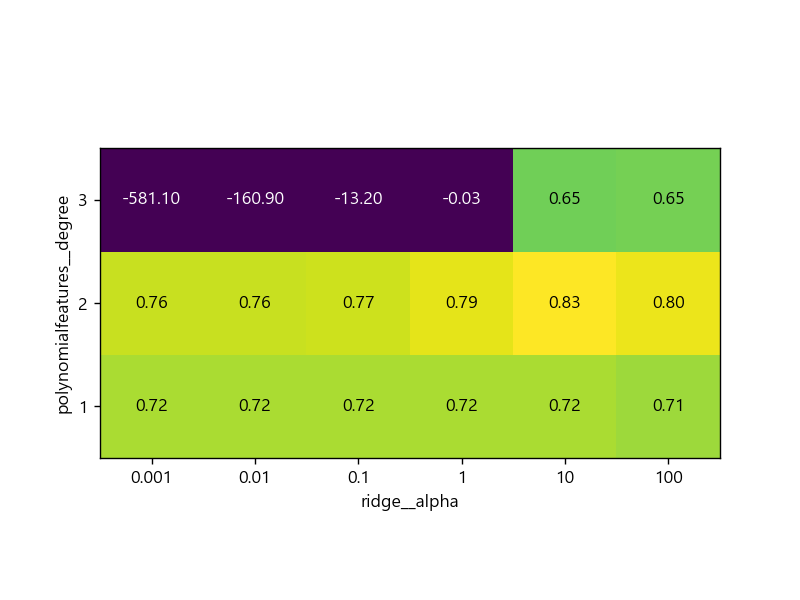

In [32]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3,-1)
                     ,xlabel='ridge__alpha',ylabel='polynomialfeatures__degree'
                     ,xticklabels=param_grid['ridge__alpha']
                     ,yticklabels=param_grid['polynomialfeatures__degree']
                     ,vmin=0)

In [34]:
print('best parametors :',grid.best_params_)

best parametors : {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [35]:
print('테스트 세트 점수 : {:.2f}'.format(grid.score(X_test,y_test)))

테스트 세트 점수 : 0.77


In [37]:
param_grid = {'ridge__alpha' : [0.001,0.01,0.1,1,10,100]}
pipe = make_pipeline(StandardScaler(),Ridge())
grid = GridSearchCV(pipe, param_grid=param_grid,cv=5).fit(X_train,y_train)
print('테스트 세트 점수 : {:.2f}'.format(grid.score(X_test,y_test)))

테스트 세트 점수 : 0.63


## 모델선택을 위한 그리드 서치

In [39]:
pipe = Pipeline([
    ('preprocessing',StandardScaler())
    ,('classifier',SVC())
])

from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier':[SVC()],'preprocessing':[StandardScaler()]
    ,'classifier__gamma':[0.001,0.01,0.1,1,10,100]
    ,'classifier__C':[0.001,0.01,0.1,1,10,100]}
    ,{'classifier':[RandomForestClassifier(n_estimators=100)]
     ,'preprocessing':[None],'classifier__max_features':[1,2,3]}
]

X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,random_state=0)

grid = GridSearchCV(pipe,param_grid=param_grid,cv=5).fit(X_train,y_train)

In [41]:
print(f'best parametor :\n{grid.best_params_}\n')
print('best cross_val_score : {:.2f}'.format(grid.best_score_))
print('test score : {:.2f}'.format(grid.score(X_test,y_test)))

best parametor :
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

best cross_val_score : 0.99
test score : 0.98


### 중복 계산 피하기

In [42]:
!pip install dask-ml

In [43]:
pipe = Pipeline([('preprocessing',StandardScaler()),('classifier',SVC())],memory='cache_folder')